# The Complete Game: Once Normal, Now Novel

## What We're Looking For
The modern professional baseball player comes from a different planet than did their old-timey, horse-and-buggy forebears. Today's game is faster, higher-scoring, and split-second timed. Most players' skill sets and repertoire are specialized and weaponized so as to befuddle, speed past, and overpower the suckers wearing the other-colored caps.

This is undisputed.

Also undisputed is that the "professional" baseball player of ~150 years ago was not a full-time, this-is-all-I-do professional. For its first few decades, baseball was a seasonal job played before crowds of maybe a few hundred spectators for the biggest games. 

And owing to the vocation's part-time nature, almost nobody crafted their game with a specialized approach — beyond some penchant, preference, or aptitude for one position or another.

Of all the positions on the diamond, the starting pitcher's role has changed the most.

Relief pitchers weren't really a structured part of the game in its fledgling years. The starting pitcher was the pitcher, and the pitcher usually pitched the entire game.

So what changed?

We'll need Pandas and its friends.

In [172]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import glob

Let's import our data, courtesy of the Lahman Database by way of the Baseball Databank repo.

In [173]:
list_of_data = glob.glob('../../_data/lahman/core/Pitching*.csv')
list_of_dfs = [pd.read_csv(filename) for filename in list_of_data]  # All of our pitching data.
homegames = pd.read_csv('../../_data/lahman/core/HomeGames.csv')  # Data about every MLB game that's ever been played.

In [174]:
for dataframe, filename in zip(list_of_dfs, list_of_data):
  dataframe['filename'] = filename

Let's squish all of our pitching data into one dataframe and see what we've got.

In [175]:
combined_df = pd.concat(list_of_dfs, ignore_index=True)

In [176]:
combined_df.columns

Index(['playerID', 'yearID', 'round', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'filename', 'stint'],
      dtype='object')

Let's drop rows for which there isn't any CG data. There aren't many of these. Records weren't great in the 1870s.

In [177]:
df = combined_df[combined_df.CG.notnull()]

We can pull all of the postseason data out of our pitching dataframe by dropping any rows where there isn't a token describing which round of the playoffs a performance's row represents. We might need this later.

In [178]:
df_postseason = df.dropna()

Okay, here's our starting dataframe.

In [195]:
df.head(3)

,playerID,yearID,round,teamID,lgID,W,L,G,GS,CG,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,filename,stint
0,becanbu01,1884,WS,NY4,AA,0,1,1,1,1,...,NaN,NaN,NaN,0,12,NaN,NaN,NaN,../../_data/lahman/core/PitchingPost.csv,NaN
1,keefeti01,1884,WS,NY4,AA,0,2,2,2,2,...,NaN,NaN,NaN,0,9,NaN,NaN,NaN,../../_data/lahman/core/PitchingPost.csv,NaN
2,radboch01,1884,WS,PRO,NL,3,0,3,3,3,...,NaN,NaN,NaN,0,3,NaN,NaN,NaN,../../_data/lahman/core/PitchingPost.csv,NaN


Let's group everything by year.

In [180]:
df_yearly = df
df_yearly = df_yearly.groupby(df_yearly.yearID).CG.mean()

Let's take a quick peek at mean CG per season, league-wide.

In [181]:
df_yearly = pd.DataFrame(df_yearly)

<AxesSubplot:xlabel='yearID'>

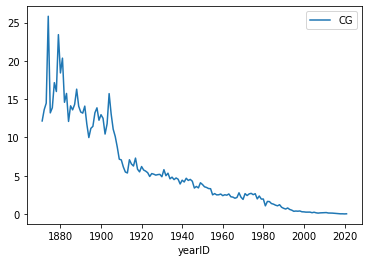

In [182]:
df_yearly.plot.line()

That looks like a strong trend. Let's write that to a csv so we can plot it elsewhere. And by elsewhere I mean ***anywhere*** else.

In [183]:
df_yearly.to_csv('yearly_cg.csv')

Since we're looking at a long-term trend, individual years — never mind individual player performances — is more granular than we need to get. So let's make a copy of our DataFrame where everything is aggregated into decade-sized buckets.

In [184]:
season_decades = df
season_decades = season_decades.groupby((season_decades.yearID//10)*10).CG.mean()
df_decades = pd.DataFrame(season_decades)

Here's the average number of Complete Games thrown per season per decade. We can already see a pretty spectacular trend.

In [185]:
df_decades.head(10)

,CG
yearID,
1870,16.047210
1880,14.353913
1890,12.490347
1900,10.956681
1910,6.261317
1920,5.377078
1930,4.786985
1940,4.080800
1950,3.018116


But let's bring in some additional context that might help us contextualize this trend. Maybe batting averages or run-scoring have gone way up over time. If League-average offensive production has dramatically increased, it would stand to reason that fewer pitchers are making it all the way through the end of the game without being replaced during the game.

In [186]:
df_decades['cg_total'] = df.groupby((df.yearID//10)*10).CG.sum()
df_decades['p_mean'] = df.groupby((df.yearID//10)*10).playerID.count() / 10
df_decades['total_pitchers'] = df.groupby((df.yearID//10)*10).playerID.count()
df_decades['League Batting Average'] = df.groupby((df.yearID//10)*10).BAOpp.median()
df_decades['median_era'] = df.groupby((df.yearID//10)*10).ERA.median()

We're going to drop the 2020s for a couple of reasons:
1. As of this writing, the 2020s aren't yet complete. And since we're looking at ~150 years' worth of historical trends, it's reasonable to end our window after 2019.
2. The COVID-19 pandemic wrecked baseball's structure in 2020. Only about half of the season's games were played, and those games were played under a temporary, atypical rule set that affected the stats that we're looking at here to a significant (albeit minor) degree.

In [187]:
df_decades = df_decades.drop(index=2020)

Let's bring in some data about the number of baseball games that have been played overall.

In [188]:
homegames = homegames.rename(columns={'year.key': 'season'})

In [189]:
homegames_decade = homegames.groupby((homegames.season//10)*10).sum()

In [190]:
homegames_decade

,season,games,openings,attendance
season,,,,
1870,204311,2031,791,1164123
1880,360043,8759,162,906016
1890,321965,9471,851,3183789
1900,318067,11342,9731,52013077
1910,352254,13324,9740,65649894
1920,313696,12323,8233,92620839
1930,326933,12311,9765,94281914
1940,326667,12376,10077,141735385
1950,316633,12374,10658,165620628


Baseball is asymmetrical in that the offense and the defense are discrete subsets of each team's participation in a game, and that the performance of those subsets is distinct and wildly different in form. The defense cannot score while the offense is batting, and the defense cannot switch to offense until the other team's offense has been retired. Compare this to hockey or basketball, where offensive and defensive roles are fluid and not expressly delimited. 

Because each team plays offense and defense equally, each game can have up to two Complete Games. And since we're looking at overall team defensive outings as a metric against which performances can be measured, we'll multiply the total number of games by two. 

In [191]:
df_decades['team_outings'] = homegames_decade.games * 2

Let's give ourselves a handy column that describes the ratio of League-total defensive outings to League-total complete games.

In [192]:
df_decades['outings_per_cg'] = df_decades['team_outings'] / df_decades['cg_total']

In [193]:
df_decades

,CG,cg_total,p_mean,total_pitchers,League Batting Average,median_era,team_outings,outings_per_cg
yearID,,,,,,,,
1870,16.047210,3739,23.3,233,NaN,3.050,4062,1.086387
1880,14.353913,16507,115.0,1150,NaN,3.805,17518,1.061247
1890,12.490347,16175,129.5,1295,NaN,4.500,18942,1.171066
1900,10.956681,17958,163.9,1639,0.2305,3.000,22684,1.263170
1910,6.261317,15215,243.0,2430,0.2600,3.170,26648,1.751430
1920,5.377078,12292,228.6,2286,0.2900,4.320,24646,2.005044
1930,4.786985,11034,230.5,2305,0.2800,4.500,24622,2.231466
1940,4.080800,10606,259.9,2599,0.2600,3.990,24752,2.333773
1950,3.018116,8330,276.0,2760,0.2600,4.165,24748,2.970948


There's plenty here to work with, now. Let's export this and boogie.

In [194]:
df_decades.to_csv('cgtrends.csv')